In [1]:
import os

from konlpy.tag import Mecab
mecab = Mecab()
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

%matplotlib inline
#모듈 로드

# 프로젝트: SentencePiece 사용하기
SentencePiece는 SentencePiece는 Google에서 제공하는 오픈소스 기반 Sentence Tokenizer/Detokenizer 로서, BPE와 unigram 2가지 subword 토크나이징 모델 중 하나를 선택해서 사용할 수 있도록 패키징한 것입니다. 
[링크](https://github.com/google/sentencepiece)

subword segmentation
하나의 단어는 더 작은 단위의 의미 요소로 이루어져 있다는 점에서 착안
birthplace = birth + place
단어를 여러 서브워드로 분리하여 단어를 인코딩 및 임베딩 함

BPE
OOV문제를 완화하는데 탁월하다.

# 네이버 영화리뷰 감정분석 문제에 SentencePiece 적용해 보기

- 네이버 영화리뷰 감정분석 코퍼스에 sentencepiece를 적용시킨 모델 학습하기

- 학습된 모델로 sp_tokenize() 메소드 구현하기

- 구현된 토크나이저를 적용하여 네이버 영화리뷰 감정분석 모델을 재학습하기

- KoNLPy 형태소 분석기를 사용한 모델과 성능 비교하기

- (보너스) SentencePiece 모델의 model_type, vocab_size 등을 변경해 가면서 성능 개선 여부 확인하기

- Word Vector는 활용할 필요가 없습니다. 활용이 가능하지도 않을 것입니다.

In [2]:
import os
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


# 전처리

In [3]:
import os
path_to_file = os.getenv('HOME')+'/aiffel/sentiment_classification/ratings_train.txt'
with open(path_to_file, "r") as f:
    raw = f.read().splitlines() #한 줄씩 읽어옴
print("Data Size:", len(raw)) #길이 확인
print("Example:")
for sen in raw[0:100][::20]: print(">>", sen) #리스트 전체에서 인덱스 0부터 20씩 증가시키면서 요소를 가져옴

Data Size: 150001
Example:
>> id	document	label
>> 3989148	약탈자를 위한 변명, 이라. 저놈들은 착한놈들 절대 아닌걸요.	1
>> 4805788	이 영화가 왜 이렇게 저평가 받는지 모르겠다	1
>> 8317483	백봉기 언제나오나요?	1
>> 9801316	아햏햏 아햏햏 아햏햏.	1


In [4]:
df = train_data
raw = df['document']
print("Data Size:", len(raw))

Data Size: 150000


In [5]:
raw.drop_duplicates()
raw.dropna(axis = 0)
  #결측치와 중복값은 없나보네요
print("Data Size:", len(raw))
raw

Data Size: 150000


0                                       아 더빙.. 진짜 짜증나네요 목소리
1                         흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나
2                                         너무재밓었다그래서보는것을추천한다
3                             교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정
4         사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...
                                ...                        
149995                                  인간이 문제지.. 소는 뭔죄인가..
149996                                        평점이 너무 낮아서...
149997                      이게 뭐요? 한국인은 거들먹거리고 필리핀 혼혈은 착하다?
149998                          청춘 영화의 최고봉.방황과 우울했던 날들의 자화상
149999                             한국 영화 최초로 수간하는 내용이 담긴 영화
Name: document, Length: 150000, dtype: object

In [6]:
#raw = list(raw)

In [7]:
#센덴스피스의 입력해야하기 때문에 데이터를 text로 저장한다
#with open(path_to_file, 'w', encoding='utf8') as f:
    #f.write('\n'.join(df['document']))#\n 한 줄에 하나씩

    
    #TypeError: sequence item 25857: expected str instance, float found 에러 발생
    #리스트에 문자열이 아닌 데이터를 sentencepiece에 입력으로 주는 방법은 뭘까.
#raw = raw.to_csv('data.txt', sep = '\n')    

문장의 최단 길이: 1
문장의 최장 길이: 146
문장의 평균 길이: 7490


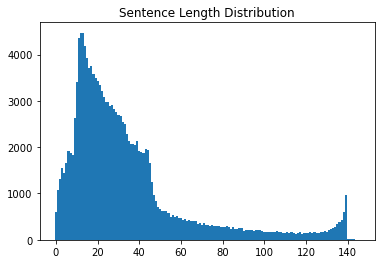

In [8]:
min_len = 999
max_len = 0
sum_len = 0

for sen in raw:
    length = len(str(sen))
    if min_len > length: min_len = length
    if max_len < length: max_len = length
    sum_len += length

print("문장의 최단 길이:", min_len)
print("문장의 최장 길이:", max_len)
print("문장의 평균 길이:", sum_len // len(str(raw))) #float는 len값을 가지지 않으므로 str(raw)식으로 수정해 사용

sentence_length = np.zeros((max_len), dtype=np.int) # 0을 원소로 가지는 넘파이 배열 형성 

for sen in raw:
    sentence_length[len(str(sen))-1] += 1 #각 길이별 문장 개수를 구하는 함수 역할

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

#포럼 질문 https://lms.aiffel.io/forum/101 참고
#np.zeros를 활용 377개의 0을 가지는 numpy 배열 생성
#각각 원소의 인덱스는 문장의 길이를 의미
#각 원소의 값이 해당 문장길이를 가진 문장의 개수
#for문을 돌려 카운트, 그래프의 Y값 역할을 수행한다.

In [9]:
for idx, _sum in enumerate(sentence_length):
    # 문장의 수가 3000을 초과하는 문장 길이를 추출합니다.
    if _sum > 3000:
        print("Outlier Index:", idx+1)

Outlier Index: 11
Outlier Index: 12
Outlier Index: 13
Outlier Index: 14
Outlier Index: 15
Outlier Index: 16
Outlier Index: 17
Outlier Index: 18
Outlier Index: 19
Outlier Index: 20
Outlier Index: 21
Outlier Index: 22
Outlier Index: 23
Outlier Index: 24


In [10]:
# 남은 데이터를 확인해봅니다

In [11]:
def check_sentence_with_length(raw, length):
    count = 0
    
    for sen in raw:
        if len(str(sen)) == length:
            print(str(sen))
            count += 1
           # if count > 100: return

In [12]:
check_sentence_with_length(raw, 140) #혼자 이렇게 긴 데이터는 뭘까요. 

데너리스 타르 가르엔...나도 용의주인이 되고 싶다...누이랑,근친상간이나 하고 다닐지라도,소설 속에선 제일 멋진 놈이 자이메 라니스터였는데,드라마속에선,드래곤(용)이 제일 멋지네(웃음)감독님 토르-2 다크 월드는 말아 잡수셨을지라도,기본 선방은 했음
아~ 진짜 조금만 더 손 좀 보면 왠만한 상업 영화 못지 않게 퀄리티 쩔게 만들어 질 수 있었는데 아쉽네요 그래도 충분히 재미있었습니다 개인적으로 조금만 더 잔인하게 더 자극적으로 노출씬도 화끈하게 했더라면 어땠을까 하는 국산영화라 많이 아낀 듯 보임
평점조절위원회에서 나왔습니다(웃음)김혜선은 @내일이 오면@의 김순정,순정이 역할이 제일이다.팜므파탈로써,그 정도까지 잘해낼 줄은,정말 의외였어...연기20년 한사람에게 요즘 사극에서 벌어지고 있는,그녀에 대한 연기논란은 왠지 코미디의한장면 같음(웃음)
사실여부를 떠나,알고왔던 아더와 너무 매칭이 안돼더라.원탁기사중 실제 검술 최고수는 랜슬롯으로 알고 있는데,트리스탄보다 못하고,싸우는 검술은 마치 중국검술 흉내낸거 같은게;; 그리고 란슬롯이 실제는 쌍검였나?너무 매칭이 안대 하튼 ㅋ기네비어역도 미스.
진짜 이건 아님ㅋㅋㅋㅋㅋ액션영화좋아해서 액션영화만 다운받아서 꾸준히 본게 벌써 몇년인 사람임 근데 이건 진짴ㅋㅋㅋㅋㅋㅋ아무리 점수 잘 줘도 100점 만점에 10점?ㅡㅡ돈주고봤는데너무아깝다진짜ㅜㅜ그리고대체 왜 13구역 타이틀을 달고나왔는지 모르겠음 실망
영화'산업'이라고 하잖는가? 이딴식으로 홍보 해놓고 속여서 팔았다는 게 소비자 입장에서는 짜증난다. 그나마 다행은 아주 싸구려를 상급품으로 속여판 게 아니라는 점. 그래서 1점. 차라리 연상호 감독 작품 처럼 홍보가 됐다면, 그 비슷하게 만이라도 하지
화려한 색채때문에 눈이 아프지만 그 나름대로 화려연예계여자욕망에대해 표현해냈던거같다 보는내내 진짜 리리코심정가진 연옌들도 있을거같고..나를한번도보지못하고알지못하는사람들이날어떻게사랑하냐그런대사 나왔을때 소름돋더라 연예인들은 많은사랑받으면서도 참 허전할듯
히가시노 게이고의 추리소

Data Size: 146183
문장의 최단 길이: 1
문장의 최장 길이: 146
문장의 평균 길이: 35


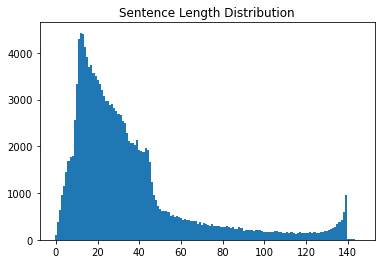

In [13]:
#중복제거
min_len = 999
max_len = 0
sum_len = 0

cleaned_corpus = list(set(raw))  # set를 사용해서 중복을 제거합니다.
print("Data Size:", len(cleaned_corpus))

for sen in cleaned_corpus:
    length = len(str(sen))
    if min_len > length: min_len = length
    if max_len < length: max_len = length
    sum_len += length

print("문장의 최단 길이:", min_len)
print("문장의 최장 길이:", max_len)
print("문장의 평균 길이:", sum_len // len(cleaned_corpus))

sentence_length = np.zeros((max_len), dtype=np.int)

for sen in cleaned_corpus:   # 중복이 제거된 코퍼스 기준
    sentence_length[len(str(sen))-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()


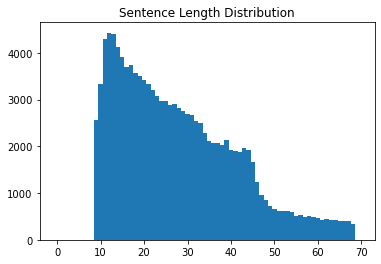

In [14]:
max_len = 70
min_len = 10
# 길이 조건에 맞는 문장만 선택합니다.
filtered_corpus = [s for s in cleaned_corpus if (len(str(s)) < max_len) & (len(str(s)) >= min_len)]
# 분포도를 다시 그려봅니다.
sentence_length = np.zeros((max_len), dtype=np.int)
for sen in filtered_corpus:
    sentence_length[len(str(sen))-1] += 1
plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()


In [15]:
# sentencepiece 활용 #하이퍼 파라미터를 설정한다.

In [16]:
import sentencepiece as spm
import os

temp_file = os.getenv('HOME')+'/aiffel/sp_tokenizer/data/korean-english-park.train.ko.temp'
templates= '--input={} \
--model_prefix={} \
--vocab_size={} \
--character_coverage={} \
--model_type={}'

with open(temp_file, 'w') as f:
    for row in filtered_corpus:   # 이전 스텝에서 정제했던 corpus를 활용합니다.
        f.write(str(row) + '\n')


#pad_id=0  #<pad> token을 0으로 설정
vocab_size = 8000 # vocab 사이즈
prefix = 'ratings_spm' # 저장될 tokenizer 모델에 붙는 이름
#bos_id=1 #<start> token을 1으로 설정
#eos_id=2 #<end> token을 2으로 설정
#unk_id=3 #<unknown> token을 3으로 설정
character_coverage = 1.0 # to reduce character set 
model_type ='unigram' # Choose from unigram (default), bpe, char, or word


cmd = templates.format(temp_file,
#                pad_id,
#                bos_id,
#                eos_id,
#                unk_id,
                prefix,
                vocab_size,
                character_coverage,
                model_type)

cmd      

'--input=/home/aiffel-dj57/aiffel/sp_tokenizer/data/korean-english-park.train.ko.temp --model_prefix=ratings_spm --vocab_size=8000 --character_coverage=1.0 --model_type=unigram'

In [17]:
#모델로드
sp = spm.SentencePieceProcessor()
sp.Load('{}.model'.format(prefix))

True

In [18]:
for t in train_data.document.values[:10]:
    print(t)
    print(sp.encode_as_pieces(t))
    print(sp.encode_as_ids(t), "\n")

아 더빙.. 진짜 짜증나네요 목소리
['▁아', '▁', '더', '빙', '..', '▁', '진', '짜', '▁', '짜', '증', '나', '네', '요', '▁', '목', '소', '리']
[46, 4, 171, 512, 27, 4, 93, 186, 4, 186, 255, 33, 72, 57, 4, 371, 150, 35] 

흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나
['▁', '흠', '...', '포', '스', '터', '보', '고', '▁', '초', '딩', '영화', '줄', '...', '.', '오', '버', '연', '기', '조', '차', '▁', '가', '볍', '지', '▁', '않', '구', '나']
[4, 706, 31, 142, 53, 143, 71, 23, 4, 208, 429, 44, 154, 31, 11, 109, 144, 106, 37, 219, 223, 4, 20, 2310, 25, 4, 536, 91, 33] 

너무재밓었다그래서보는것을추천한다
['▁너무', '재', '밓', '었', '다', '그', '래', '서', '보', '는', '것', '을', '추', '천', '한', '다']
[62, 137, 1539, 120, 18, 98, 101, 55, 71, 21, 113, 29, 214, 321, 30, 18] 

교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정
['▁', '교', '도', '소', '▁이', '야', '기', '구', '먼', '▁', '..', '솔', '직', '히', '▁', '재', '미', '는', '▁', '없', '다', '..', '평', '점', '▁', '조', '정']
[4, 205, 22, 150, 67, 66, 37, 91, 473, 4, 27, 683, 233, 102, 4, 137, 82, 21, 4, 149, 18, 27, 439, 59, 4, 219, 92] 

사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어

In [19]:
s = spm.SentencePieceProcessor()
s.Load('korean_spm.model')

# SentencePiece를 활용한 sentence -> encoding
tokensIDs = s.EncodeAsIds('아버지가방에들어가신다.')
print(tokensIDs)

# SentencePiece를 활용한 sentence -> encoded pieces
print(s.SampleEncodeAsPieces('아버지가방에들어가신다.',1, 0.0))

# SentencePiece를 활용한 encoding -> sentence 복원
print(s.DecodeIds(tokensIDs))

[1244, 11, 306, 7, 3599, 11, 286, 38, 3]
['▁아버지', '가', '방', '에', '들어', '가', '신', '다', '.']
아버지가방에들어가신다.


In [20]:
#데이터를 모델에 넣을 수 있도록 임베딩해주는 함수.
def sp_tokenize(s, corpus):

    tensor = []

    for sen in corpus:
        tensor.append(s.EncodeAsIds(sen))

    with open("./korean_spm.vocab", 'r') as f:
        vocab = f.readlines()

    word_index = {}
    index_word = {}

    for idx, line in enumerate(vocab):
        word = line.split("\t")[0]

        word_index.update({idx:word})
        index_word.update({word:idx})

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='pre',maxlen=80)#패딩추가

    return tensor, word_index, index_word

In [21]:
my_corpus = ['나는 밥을 먹었습니다.', '그러나 여전히 ㅠㅠ 배가 고픕니다...']
tensor, word_index, index_word = sp_tokenize(s, my_corpus)
print(tensor)

[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0 1949 5662    5    4 7975 1983    3]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0  107 1638  101    4
     0  419   11    4   14    0 1969    3    3    3]]


In [41]:
tensor, word_index, index_word = sp_tokenize(s, filtered_corpus)
print(tensor)

[[   0    0    0 ... 2015    3    3]
 [   0    0    0 ... 1686   14 1296]
 [   0    0    0 ... 7610   25 4293]
 ...
 [   0    0    0 ... 2901   38    3]
 [   0    0    0 ...   38    3    3]
 [   0    0    0 ...  829  520    3]]


In [42]:
tensor.shape #train_test_split을 진행하려는데 inconsistent numbers of samples error가 떠서 찾아봤습니다
#데이터와 레이블 길이가 맞지 않아 생기는 에러라고 합니다.
#데이터 document부분을 전처리 하며 데이터들을 제거해줬기 때문에 생긴 에러.

(119419, 80)

In [43]:
train_data = train_data[train_data['document'].str.len() < max_len]   filtered_corpus

In [45]:
train_data = filtered_corpus[filtered_corpus['document'].str.len() < max_len]

TypeError: list indices must be integers or slices, not str

In [44]:
len(list(train_data['label']))  #15000이기 때문에 tensor와 길이를 맞춰줄 필요가 있다.

133154

In [32]:
#train_data = train_data[(train_data['document'].map(len) <= max_len)*(train_data['document'].map(len) >= min_len)]
#max_len = 70보다 작은 범위 내에서 cleaned_corpus를 정제해준 후 이 데이터 자체에서 슬라이싱을 실행
#TypeError: list indices must be integers or slices, not str
#리스트 안에 있는 인덱스들 값이 str이 아니라 정수나 slice여야한다는 이야기.

In [37]:
#train_test를 사용할 수 없으니 슬라이싱을 사용해준다 #그런데 document값과 label값이 짝을 이뤄야하는데 이렇게 해도 괜찮을까 고민했더니 괜찮다고 하네요...!
X_train = tensor[:80000]
X_test = tensor[80000:]
#y_train = np.array(list(train_data['label'](len) < max_len))
y_train = np.array(list(test_data['label']))
y_test = np.array(list(test_data['label']))


print("X_train shape :" , X_train.shape)
print("y_train shape :" , y_train.shape)
print("x_test shape :" , X_train.shape)
print("y_test shape :" , y_test.shape)


X_train shape : (80000, 80)
y_train shape : (50000,)
x_test shape : (80000, 80)
y_test shape : (50000,)


● Slice Notation 사용
python 내장함수인 slice notation을 사용하여 데이터를 자를 수 있습니다.

slice는 start:stop[:step]의 형식으로 쓸 수있습니다. 여기서 [:step]은 써도 되고 안써도 된다는 의미입니다.

step을 명시하지 않을 경우에는

a[start:end] # start부터 end-1까지의 item
a[start:] # start부터 리스트 끝까지 item
a[:end] # 처음부터 end-1까지의 item
a[:] # 리스트의 모든 item


출처: https://ebbnflow.tistory.com/126 [Dev Log : 삶은 확률의 구름]

In [ ]:
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
model = Sequential()
model.add(Embedding(vocab_size, 100)) #임베딩 레이어 추가
model.add(LSTM(128))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [ ]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=60, validation_split=0.2)
#validation_split=0.2는 train의 0.2를 validation으로 사용한다. 

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

fig,(ax0, ax1) = plt.subplots(nrows = 1, ncols = 2, sharey = False)
ax0.plot(history.history["acc"], label = 'acc')
ax0.set(title='Accuracy')
ax1.plot(history.history["loss"], label = 'loss')
ax1.set(title='Accuracy')

In [ ]:
result = model.evaluate(X_test, y_test, verbose=1 )
print(result)

`ERROR`
**ValueError: Data cardinality is ambiguous:**

1. As the Error suggests, the First Dimension of X and y is different. First Dimension indicates the Batch Size and it should be same. => 배치 사이즈를 60으로 통일해주었다 => 해결 안됨 => x test와 y test의 길이가 맞지 않은 것이 문제. 데이터 정제 과정을 다시 살펴보기로 했다      


2. 해당 다큐먼트에 맞는 레이블은 정제되지 않은 원본 데이터이기 때문에 document파일을 정제할때 처럼 레이블도 같은 방식으로 잘라준 후 레이블과 document의 길이를 맞춰준다. < train, test데이터를 나눠주기 이전에 확인해야할 부분.